In [1]:
import numpy  
import matplotlib 
import scipy 

print("NumPy version:", numpy.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SciPy version:", scipy.__version__)

NumPy version: 1.22.3
Matplotlib version: 3.5.2
SciPy version: 1.8.0


In [2]:
import os
import datetime
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"="*8 + "%s"%nowtime)

printbar()


========2024-05-31 11:36:26


In [3]:
import numpy as np
from numpy import exp, pi
t32 = np.linspace(0, 1, 32*1024)
sw32 = np.linspace(0, len(t32)/t32.max(), len(t32))
def spec( f, T2, t, A0=1 ):
    """Spectral peak
    Parameters.
    - f: frequency 
    - T2: spin-spin relaxation time (s)
    - t: time domain (s)
    - A0: initial amplitude, default is 1
    
    Returns: Spectrum signal
    """
    fid = A0*exp(1j*2*pi*(f)*t)*exp(-t/T2)
    spec_tep = np.fft.fft(fid)/(np.fft.fft(fid).real.max())  
    return  spec_tep - spec_tep.real.min()

In [4]:
file_t= r'plasma_noesypr1d.txt'
with open(file_t,"r") as file:
    string = file.readlines() 
noesypr1d_tep_list = []
for i in string:
    if i[0] != '#':
        noesypr1d_tep_list.append(float(i))
        
low = float(string[3][string[3].index('LEFT =')+7:string[3].index('RIGHT = ')-6])
high = float(string[3][string[3].index('RIGHT =')+8:-6])
si = int(string[5][9:string[5].index('(')-1])
sw_ppm = np.linspace(low , high, si )
print('spectral width in ppm: From {} To {}'.format(np.round(low,3), np.round(high, 3)))
noesypr1d_np = np.array(noesypr1d_tep_list)
print(noesypr1d_np.shape)    

spectral width in ppm: From 14.833 To -5.194
(131072,)


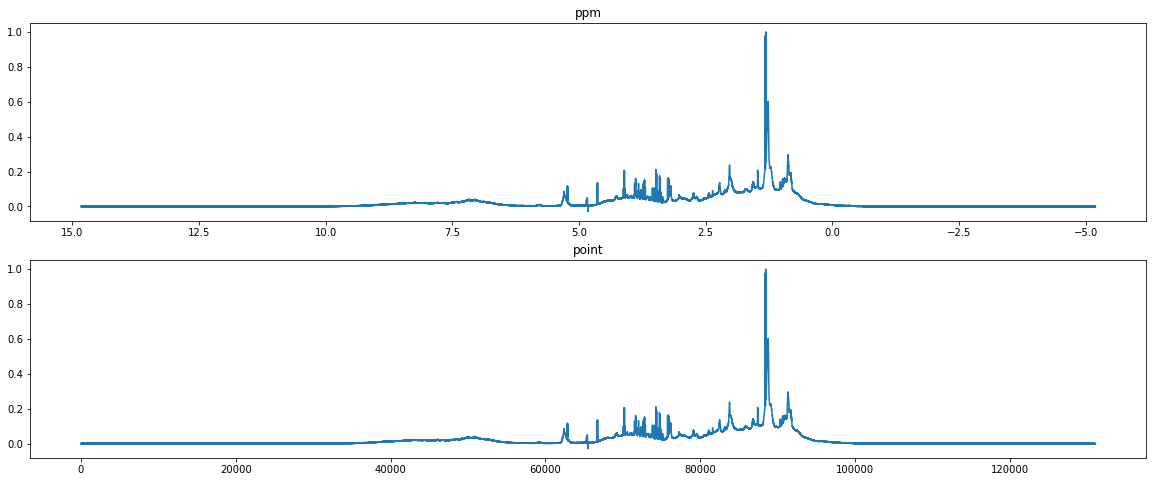

In [5]:
import matplotlib.pyplot as plt
noesypr1d_128k = noesypr1d_np/noesypr1d_np.max()
plt.figure(figsize= (20,8))
plt.subplot(2,1,1)
plt.plot(sw_ppm, noesypr1d_128k  )
plt.gca().invert_xaxis()
plt.title('ppm')
plt.subplot(2,1,2)
plt.plot(noesypr1d_128k )
plt.title('point')
plt.show()

In [6]:
# water peak region
for i in range(0, 128*1024):
    if sw_ppm[i] < 4.657:  
        print('{:.3f} ppm'.format(sw_ppm[i]), i)
        water_r = i
        break
for i in range(0, 128*1024):
    if sw_ppm[i] < 5.130: 
        print('{:.3f} ppm'.format(sw_ppm[i]), i)
        water_l = i
        break     

4.657 ppm 66599
5.130 ppm 63503


In [7]:
noesypr1d_128k[water_l: water_r] = 0 
noesypr1d_128k -= noesypr1d_128k.min()
noesypr1d_128k.shape, noesypr1d_128k.max(), noesypr1d_128k.min() 

((131072,), 1.0030268384832848, 0.0)

154


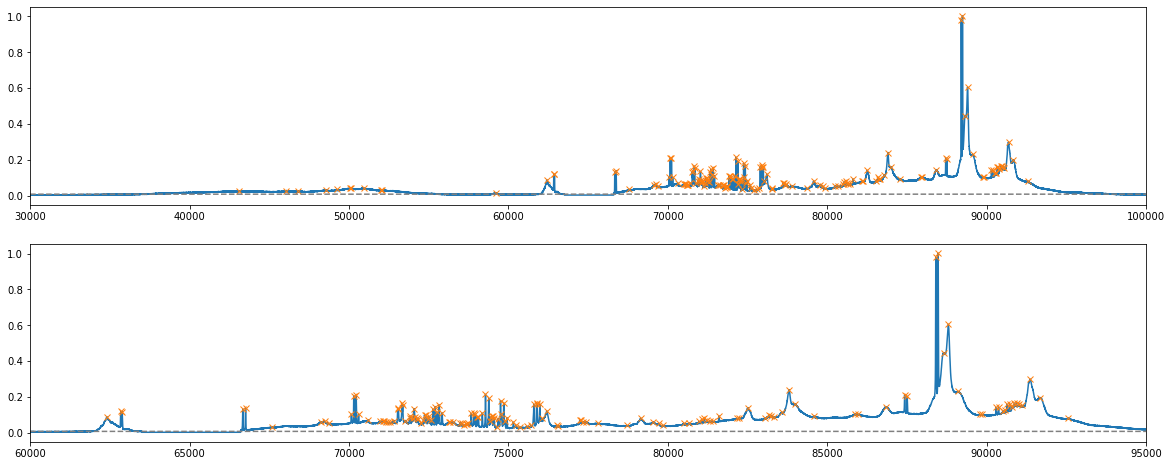

In [8]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
height = 0.008   
peaks, _ = find_peaks(noesypr1d_128k, height=height, prominence=0.005) 
results_half = peak_widths(noesypr1d_128k, peaks, rel_height=0.5)
plt.figure(figsize= (20,8))
plt.subplot(2,1,1)
plt.plot(noesypr1d_128k)
plt.plot(peaks, (noesypr1d_128k)[peaks], "x")
plt.plot(np.zeros_like(noesypr1d_128k) + height, "--", color="gray")
plt.xlim(30000,100000)
plt.subplot(2,1,2)
plt.plot(noesypr1d_128k)
plt.plot(peaks, (noesypr1d_128k)[peaks], "x")
plt.plot(np.zeros_like(noesypr1d_128k) + height, "--", color="gray")
plt.xlim(60000,95000)
print(len(peaks))  
plt.show()

In [9]:
spec_all_noesypr1d_pro = 0
spec_all_noesypr1d_h = 0
for p, w, h, pro in zip(peaks, results_half[0], results_half[1], _['prominences']): 
    spec_all_noesypr1d_pro += spec(int(p/4), 1/(3.14*w*0.25), t32, 1)*pro
    spec_all_noesypr1d_h += spec(int(p/4), 1/(3.14*w*0.25), t32, 1)*h
print(len(peaks) )

154


In [10]:
spec_all_noesypr1d_pro_ = np.fft.fft(np.fft.ifft(spec_all_noesypr1d_pro), 128*1024).real
spec_all_noesypr1d_h_ = np.fft.fft(np.fft.ifft(spec_all_noesypr1d_h), 128*1024).real
spec_all_noesypr1d_pro_ /= spec_all_noesypr1d_pro_.max()
spec_all_noesypr1d_h_ /= spec_all_noesypr1d_h_.max()

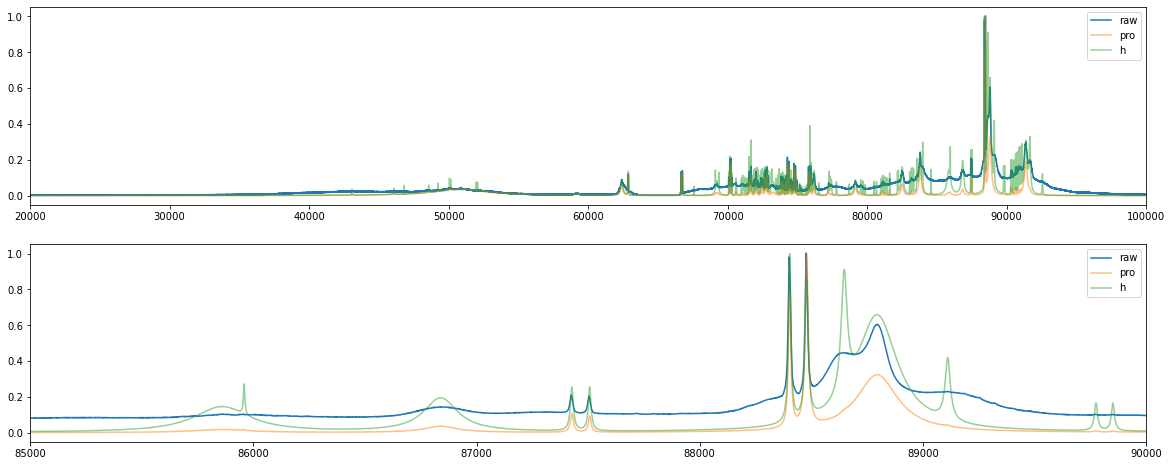

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(noesypr1d_128k, label = 'raw')
plt.plot(spec_all_noesypr1d_pro_, alpha = 0.5, label = 'pro')
plt.plot(spec_all_noesypr1d_h_ , alpha = 0.5, label = 'h')
plt.xlim(20000, 100000)
plt.legend()
plt.subplot(2,1,2)
plt.plot(noesypr1d_128k, label = 'raw')
plt.plot(spec_all_noesypr1d_pro_, alpha = 0.5, label = 'pro')
plt.plot(spec_all_noesypr1d_h_ , alpha = 0.5, label = 'h')
plt.xlim(85000, 90000)
plt.legend()
plt.show()

In [12]:
spec_all_noesypr1d_pro_small = 0
spec_all_noesypr1d_pro_large = 0
small_peaks = []
large_peaks = []
for p, w, h, pro in zip(peaks,results_half[0],results_half[1],_['prominences']): 
    if w <= 30:   
        spec_all_noesypr1d_pro_small += spec(int(p/4),1/(3.14*w*0.25),t32,1)*pro
        small_peaks.append((int(p/4), w, h, pro))
    elif w > 50:  
        spec_all_noesypr1d_pro_large += spec(int(p/4),1/(3.14*w*0.25),t32,1)*pro
        large_peaks.append((int(p/4), w, h, pro))
print(len(peaks),  len(small_peaks), len(large_peaks))

154 122 18


In [13]:
spec_all_noesypr1d_pro_small_ = np.fft.fft(np.fft.ifft(spec_all_noesypr1d_pro_small), 128*1024).real
spec_all_noesypr1d_pro_large_ = np.fft.fft(np.fft.ifft(spec_all_noesypr1d_pro_large), 128*1024).real

spec_all_noesypr1d_pro_small_ /= spec_all_noesypr1d_pro_small_.max()
spec_all_noesypr1d_pro_large_ /= spec_all_noesypr1d_pro_large_.max()

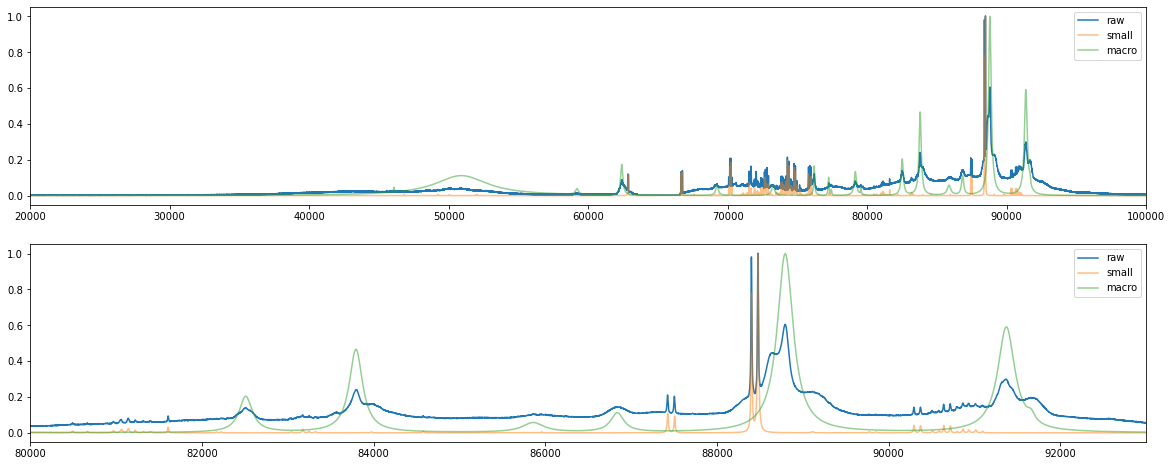

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(noesypr1d_128k,   label = 'raw')
plt.plot(spec_all_noesypr1d_pro_small_ , alpha = 0.5, label = 'small')
plt.plot(spec_all_noesypr1d_pro_large_ , alpha = 0.5, label = 'macro')
plt.xlim(20000, 100000)
plt.legend()
plt.subplot(2,1,2)
plt.plot(noesypr1d_128k,   label = 'raw')
plt.plot(spec_all_noesypr1d_pro_small_ , alpha = 0.5, label = 'small')
plt.plot(spec_all_noesypr1d_pro_large_ , alpha = 0.5, label = 'macro')
plt.xlim(80000, 93000)
plt.legend()
plt.show()  

In [15]:
import random
from tqdm import tqdm 
spe_all_fid_list = []
spe_large_fid_list = []
for _ in tqdm(range(4)):
    spec_all_small = 0
    spec_all_small_2 = 0
    spec_all_large = 0
    
    peaks_small_1 = np.random.choice(range(5, 20))
    peaks_small_2 = np.random.choice(range(5, 10))
    peaks_large = np.random.choice(range(5, 20))
    for f,w,h,pro in random.sample(small_peaks, 120):      
        A = np.random.uniform(0.1, 5) 
        f_f = np.random.uniform(-20, 20) 
        f_T2 = np.random.uniform(0.75, 1.5) 
        if f_T2/(3.14*0.25*w) > 0.2:
            re_T2 = np.random.uniform(0.5, 0.75)  
            T_re = min((f_T2/(3.14*0.25*w)), 0.2)*re_T2
        else:
            T_re = (f_T2/(3.14*0.25*w))                        
        spec_all_small += h*A*spec(f+f_f, T_re, t32)  
        
    for f,w,h,pro in large_peaks:  
        A = np.random.uniform(0.1, 5) 
        f_f = np.random.uniform(-50, 50)
        f_T2 = np.random.uniform(0.2 , 0.6) 
        fac2 = np.random.uniform(0.5 , 2) 
        fac3 = np.random.uniform(0.2 , 0.6) 
        spec_all_small_2 += h*A*spec(f, f_T2/(3.14*0.25*w), t32) + fac2*h*A*spec(f+f_f, fac3*1/(3.14*0.25*w), t32)
        
    for i in range(10):  
        f = np.random.randint(11055,11165)  
        A = np.random.uniform(0.001, 1) 
        T2 = np.random.uniform(0.0025, 0.01)  
        spec_all_small_2 += A*spec(f*2, T2, t32) 
        
    for i in range(10):  
        f = np.random.randint(11380,11500)  
        A = np.random.uniform(0.001, 0.5) 
        T2 = np.random.uniform(0.0025, 0.01)   
        spec_all_small_2 += A*spec(f*2, T2, t32) 
        
    for f,w,h,pro in random.sample(small_peaks, 30):
        A = np.random.uniform(0.2, 0.5*2) 
        f_f = np.random.uniform(-200, 200)
        T2 = np.random.uniform(0.0006, 0.001 ) 
        spec_all_small_2 += h*A*spec(f+f_f, T2, t32) 

    for i in range(1, peaks_small_1+1):         
        A = np.random.uniform(0.01,0.25*2*2) 
        f = np.random.randint(2500/2,26*1000/2)
        T2 = np.random.uniform(0.03, 0.2 ) 
        spec_all_small += A*spec(f*2, T2, t32)
    
    for i in range(1, peaks_small_2 ):         
        f = np.random.randint(200,26*100)  
        delta_A = np.random.uniform(0.05*2, 0.2*2) 
        T2 = np.random.uniform(0.0006, 0.001 )  
        spec_all_small_2 += 1*delta_A*spec(f*10, T2, t32)  
  
    for i in range(10, peaks_large+50):
        A = np.random.uniform(0.01*5,0.2*2) 
        f = np.random.randint(40*5, 600*2) 
        T2 = np.random.uniform(0.0000002, 0.000001 )
        spec_all_large += A*spec(f*10,T2,t32)
           
    spec_all = spec_all_small + spec_all_small_2 + spec_all_large    
    fid_all = np.fft.ifft(spec_all)
    
    # add noise
    u = 1e-5*np.random.randint(0.5, 5) 
    noise_32 = u*(np.random.randn(len(t32))+1j*np.random.randn(len(t32)))
    fidall_base_all = fid_all + noise_32
    
    spe_all = np.fft.fft(fidall_base_all) 

    spe_all_fid = np.fft.ifft(spe_all) 
    spe_large_fid = np.fft.ifft(spec_all_large + spec_all_small_2) 
    spe_small_fid = np.fft.ifft(spec_all_small) 
    
    spe_all_fid_list.append(spe_all_fid) 
    spe_large_fid_list.append(spe_large_fid) 
print('Done') 


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

Done


In [16]:
import random
peak_list1 = []
peak_list2 = []
peak_list3 = []
peak_list4 = []
peak_list5 = []
peak_list6 = []
for numbers in tqdm(range(10000)):
    peaks_small_1 = np.random.choice(range(5, 20))
    peaks_small_2 = np.random.choice(range(5, 10))
    peaks_large = np.random.choice(range(5, 20))
        
    for f,w,h,pro in random.sample(small_peaks, 120):
        A = np.random.uniform(0.5, 5) 
        f_f = np.random.uniform(-20, 20) 
        f_T2 = np.random.uniform(0.75, 1.5) 
        if f_T2/(3.14*0.25*w) > 0.2:
            re_T2 = np.random.uniform(0.5, 0.75)  
            T_re = min((f_T2/(3.14*0.25*w)), 0.2)*re_T2
        else:
            T_re = (f_T2/(3.14*0.25*w))
        peak_list1.append(T_re)   
        
    for f,w,h,pro in large_peaks:  
        A = np.random.uniform(0.1, 5) 
        f_f = np.random.uniform(-50, 50)
        f_T2 = np.random.uniform(0.2 , 0.6)   
        peak_list2.append(f_T2/(3.14*0.25*w))
        
    for i in range(10):  
        f = np.random.randint(11055,11165)  
        A = np.random.uniform(0.001, 1) 
        T2 = np.random.uniform(0.0025, 0.01)  
        peak_list2.append(T2)
        
    for i in range(10):  
        f = np.random.randint(11380,11500)  
        A = np.random.uniform(0.001, 0.5) 
        T2 = np.random.uniform(0.0025, 0.01)  
        peak_list2.append(T2)            

    for f,w,h,pro in random.sample(small_peaks, 30):
        A = np.random.uniform(0.2, 0.5*2) 
        f_f = np.random.uniform(-200, 200)
        T2 = np.random.uniform(0.0006, 0.001 ) 
        peak_list3.append(T2)

    for i in range(1, peaks_small_1+1):
        A = np.random.uniform(0.01, 0.25*2*2) 
        f = np.random.randint(2500/2, 26*1000/2)
        T2 = np.random.uniform(0.03, 0.2) 
        peak_list4.append(T2)
    
    for i in range(5, peaks_small_2 ):  
        f = np.random.randint(200, 26*100)  
        delta_A = np.random.uniform(0.05*2, 0.2*2) 
        T2 = np.random.uniform(0.0006, 0.001 )  
        peak_list5.append(T2)     
  
    for i in range(10, peaks_large+50):
        A = np.random.uniform(0.01*5, 0.2*2) 
        f = np.random.randint(40*5, 600*2) 
        T2 = np.random.uniform(0.0000002, 0.000001 )
        peak_list6.append(T2)   
             
print('Done')   

100%|██████████| 10000/10000 [00:19<00:00, 514.15it/s]

Done


0.03340110189919865 0.030000094202641225 0.014656312050057518


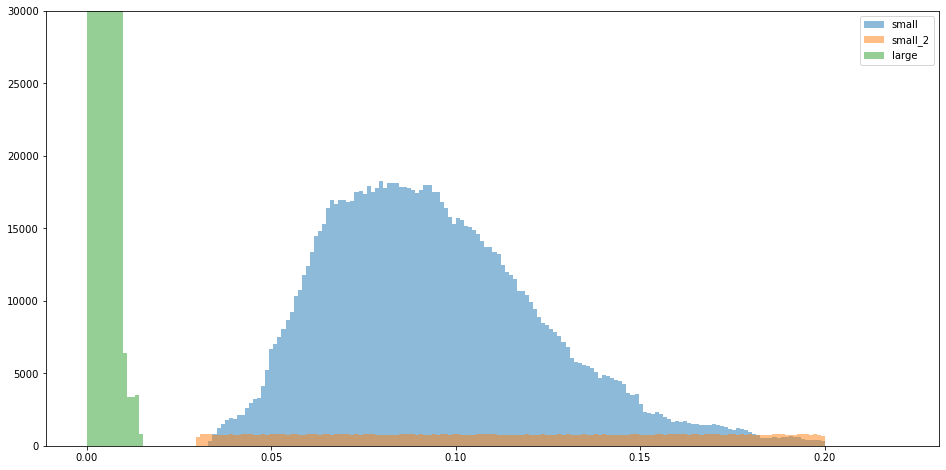

In [17]:
peak_list_small = peak_list1+peak_list4
peak_list_large = peak_list2+peak_list3+peak_list5+peak_list6
plt.figure(figsize=(16,8))
plt.hist(peak_list1, range=(0, 0.22), bins=200, alpha= 0.5,label = 'small')
plt.hist(peak_list4, range=(0, 0.22), bins=200, alpha= 0.5,label = 'small_2')
plt.hist(peak_list_large, range=(0, 0.22), bins=200, alpha= 0.5,label = 'large')
plt.legend()
print(min(peak_list1), min(peak_list4), max(peak_list_large) )
plt.ylim(0, 30000)
plt.show()

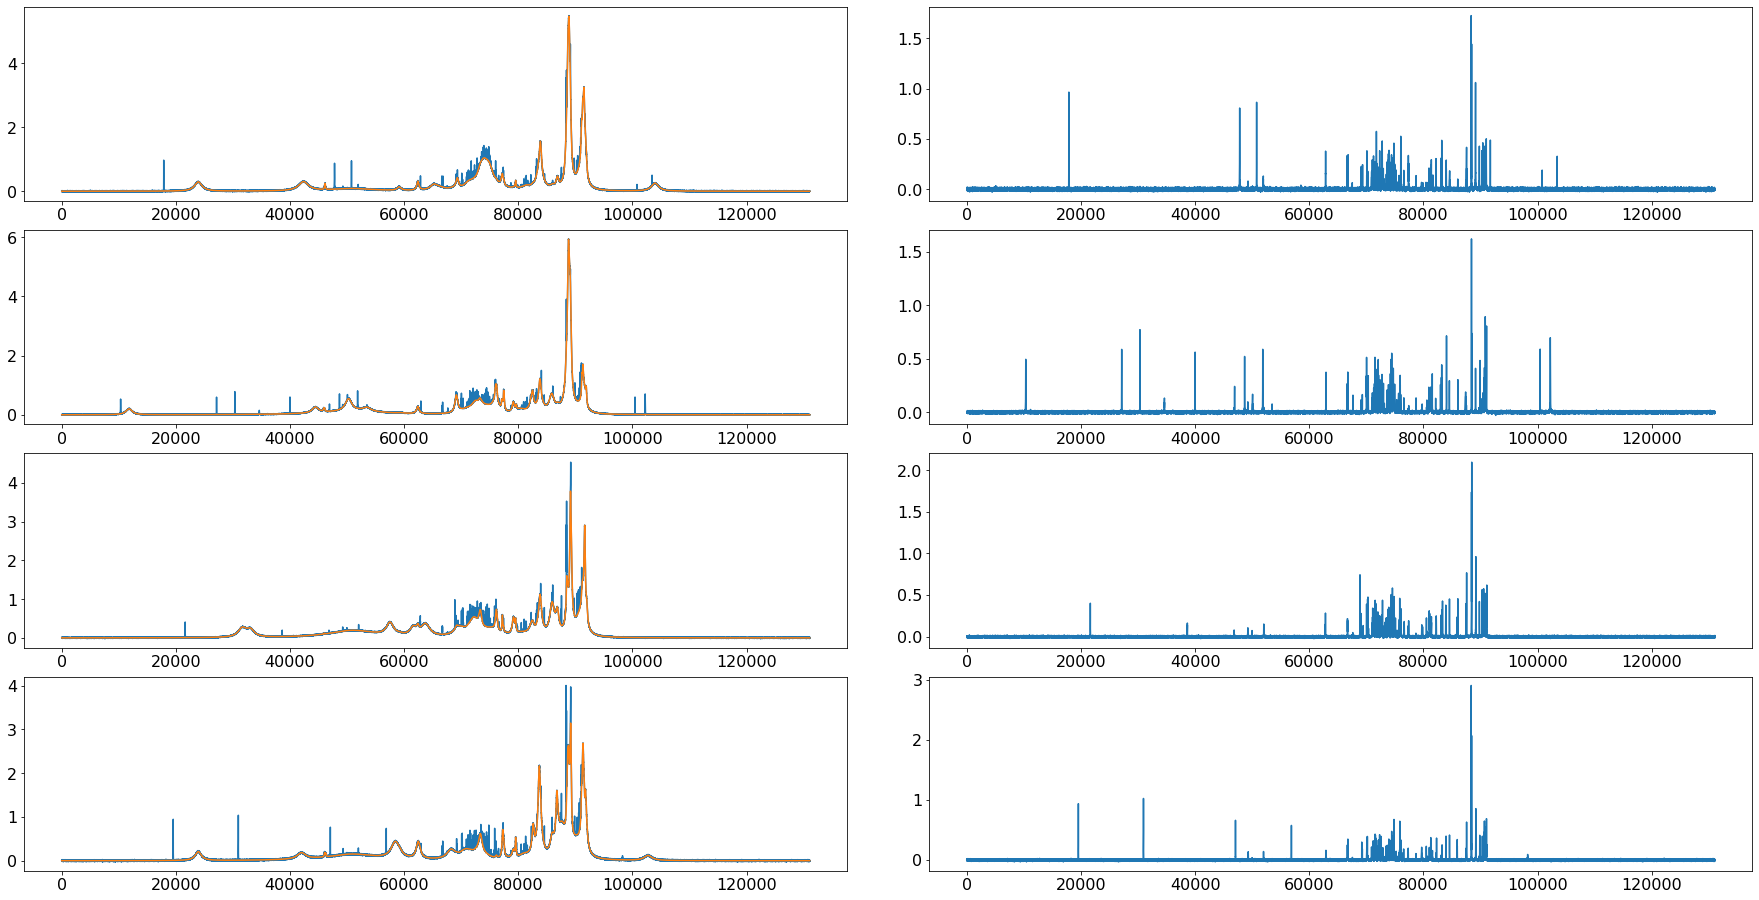

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize= (30, 15))
for n,(i,j) in enumerate(zip(spe_all_fid_list, spe_large_fid_list)):
    plt.subplot(4,2,2*n+1)
    plt.plot(np.fft.fft(i, 128*1024).real)
    plt.plot( np.fft.fft(j, 128*1024).real)
    plt.tick_params(labelsize=16)
    plt.subplot(4,2,2*n+2)
    plt.plot(np.fft.fft(i, 128*1024).real -np.fft.fft(j, 128*1024).real)
    plt.tick_params(labelsize=16)
plt.subplots_adjust(top=0.9,bottom=0.1,left=0.1 ,right=0.9,hspace=0.15,wspace=0.1)
plt.show()  

154


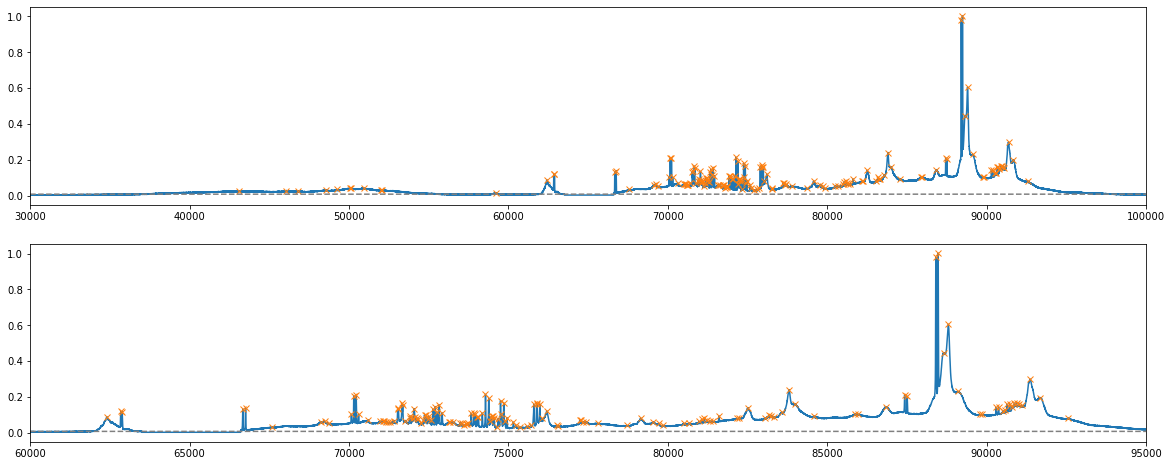

In [19]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
height = 0.008   
peaks, _ = find_peaks(noesypr1d_128k, height=height, prominence=0.005) 
results_half = peak_widths(noesypr1d_128k, peaks, rel_height=0.5)
plt.figure(figsize= (20,8))
plt.subplot(2,1,1)
plt.plot(noesypr1d_128k)
plt.plot(peaks, (noesypr1d_128k)[peaks], "x")
plt.plot(np.zeros_like(noesypr1d_128k) + height, "--", color="gray")
plt.xlim(30000,100000)
plt.subplot(2,1,2)
plt.plot(noesypr1d_128k)
plt.plot(peaks, (noesypr1d_128k)[peaks], "x")
plt.plot(np.zeros_like(noesypr1d_128k) + height, "--", color="gray")
plt.xlim(60000,95000)
print(len(peaks))  
plt.show()

In [20]:
# digiter filter
spec_all_small = 0
for p, w, h, pro in zip(peaks, results_half[0], results_half[1], _['prominences']): 
    if w <= 40: 
        spec_all_small += pro*spec(int(p/4),1/(3.14*w*0.25),t32,1)
 
spec_all_small_128 = np.fft.fft(np.fft.ifft(spec_all_small), 128*1024).real
spec_all_small_128.shape   

(131072,)

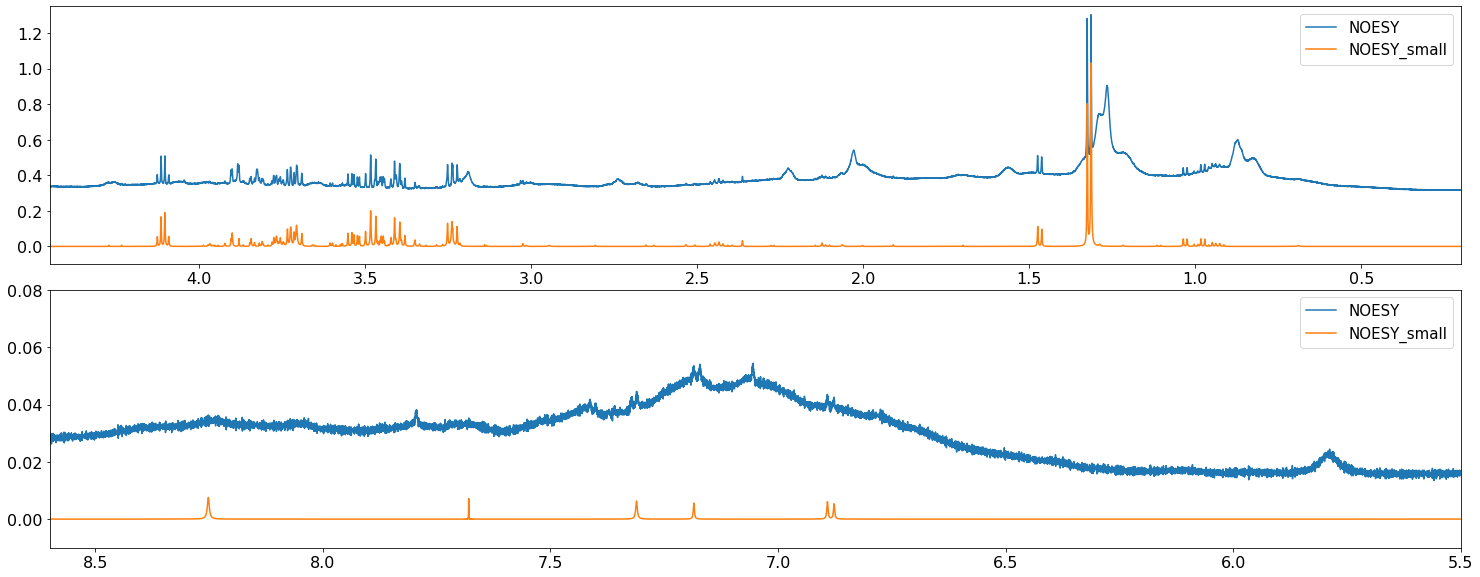

In [21]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(sw_ppm, noesypr1d_128k + 0.3, label = 'NOESY') 
plt.plot(sw_ppm, spec_all_small_128*1 , label = 'NOESY_small') #, alpha = 0.5
plt.xlim(4.45, 0.2)
plt.ylim(-0.1, 1.05+0.3)
plt.legend(fontsize=15, markerscale=1.5, scatterpoints=1)
plt.subplots_adjust(top=0.99,bottom=0.05,left=0.01 ,right=0.99,hspace=0.1,wspace=0.2)
plt.tick_params(labelsize=16)
plt.subplot(2,1,2)
plt.plot(sw_ppm, noesypr1d_128k + 0.01  , label = 'NOESY') 
plt.plot(sw_ppm, spec_all_small_128 , label = 'NOESY_small') 
plt.xlim(8.6, 5.5)
plt.ylim(-0.01 ,0.08)
plt.legend(fontsize=15, markerscale=1.5, scatterpoints=1)
plt.tick_params(labelsize=16)
plt.subplots_adjust(top=0.99,bottom=0.05,left=0.01 ,right=0.99,hspace=0.1,wspace=0.2)

plt.show()